In [2]:
import tensorflow as tf
import keras
from keras import backend as bk
import timeit

import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time

from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm
import time
from datetime import datetime
import matplotlib.animation as animation
from IPython.display import display, clear_output


physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [84]:
##############################################################################################################
###################################### Linear Modules ########################################################
##############################################################################################################


class linear_module_up:
    
    def __init__(self):
        self.a11 = tf.Variable(rdm.choice([-1,1])*rdm.random()) #tf.constant(rdm.random()) 
        self.a12 = tf.Variable(rdm.choice([-1,1])*rdm.random()) #tf.constant(rdm.random()) 
        self.a21 = tf.Variable(rdm.choice([-1,1])*rdm.random()) #tf.constant(rdm.random()) 
        self.a22 = tf.Variable(rdm.choice([-1,1])*rdm.random()) #tf.constant(rdm.random())
        self.O = tf.reshape(tf.stack([0., 0., 0., 0.]),(2,2))
        self.I = tf.reshape(tf.stack([1., 0., 0., 1.]),(2,2))
        
    
    def run(self, X):
        A = tf.reshape(tf.stack([self.a11, self.a12, self.a21, self.a22]),(2,2))
        S = A + tf.transpose(A)
        L = tf.concat([tf.concat([self.I, S],1), tf.concat([self.O, self.I],1)],0)
        return tf.matmul(L, X)
    
    def Variables(self):
        return [self.a11, self.a12, self.a21, self.a22]
    
    def grad_des(self, grad_ij, rate):

        self.a11 = tf.Variable(self.a11 - rate*grad_ij[0])
        self.a12 = tf.Variable(self.a12 - rate*grad_ij[1]) 
        self.a21 = tf.Variable(self.a21 - rate*grad_ij[2]) 
        self.a22 = tf.Variable(self.a22 - rate*grad_ij[3])
        
class linear_module_low:
    
    def __init__(self):
        self.a11 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        self.a12 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        self.a21 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        self.a22 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        self.O = tf.reshape(tf.stack([0.,0.,0.,0.]),(2,2))
        self.I = tf.reshape(tf.stack([1.,0.,0.,1.]),(2,2))
    
    def run(self, X):
        A = tf.reshape(tf.stack([self.a11,self.a12,self.a21,self.a22]),(2,2))
        S = A + tf.transpose(A)
        L = tf.concat([tf.concat([self.I, self.O],1), tf.concat([S, self.I],1)],0)
        return tf.matmul(L, X)
    
    def Variables(self):
        return [self.a11, self.a12, self.a21, self.a22]
    
    def grad_des(self, grad_ij, rate):

        self.a11 = tf.Variable(self.a11 - rate*grad_ij[0])
        self.a12 = tf.Variable(self.a12 - rate*grad_ij[1]) 
        self.a21 = tf.Variable(self.a21 - rate*grad_ij[2]) 
        self.a22 = tf.Variable(self.a22 - rate*grad_ij[3])

##############################################################################################################
###################################### Activation Modules ####################################################
##############################################################################################################

class activation_module_up:
    
    def __init__(self):
        self.a1 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        self.a2 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        
    
    def run(self, X):
        zero = tf.constant(0.)
        A = tf.reshape(tf.stack([self.a1, zero, zero, self.a2]),(2,2))

        N1 = tf.matmul(A, tf.math.sigmoid(X[2:4])) + X[0:2]

        N = tf.reshape(tf.stack([N1, X[2:4]]),(4,1))

        return N
    
    def Variables(self):
        return [self.a1, self.a2]
    
    def grad_des(self, grad_ij, rate):

        self.a1 = tf.Variable(self.a1 - rate*grad_ij[0])
        self.a2 = tf.Variable(self.a2 - rate*grad_ij[1]) 

        
class activation_module_low:
    
    def __init__(self):
        self.a1 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        self.a2 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        
    
    def run(self, X):
        zero = tf.constant(0.)
        A = tf.reshape(tf.stack([self.a1, zero, zero, self.a2]),(2,2))

        N2 = tf.matmul(A, tf.math.sigmoid(X[0:2])) + X[2:4]

        N = tf.reshape(tf.stack([X[0:2], N2]),(4,1))
        
        return N
    
    def Variables(self):
        return [self.a1, self.a2]
    
    def grad_des(self, grad_ij, rate):

        self.a1 = tf.Variable(self.a1 - rate*grad_ij[0])
        self.a2 = tf.Variable(self.a2 - rate*grad_ij[1]) 

        


In [85]:
class SympNet:

    def __init__(self):
        
        self.L1 = linear_module_up()
        self.L2 = linear_module_low()
        
        self.A1 = activation_module_up()
        
        self.L3 = linear_module_up()
        self.L4 = linear_module_low()
        
        self.A2 = activation_module_low()

        self.L5 = linear_module_up()
        self.Lout = linear_module_low()


    def run(self, X):
        
        boom = self.L1.run(X)
        boom1 = self.L2.run(boom)
        
        boom2 = self.A1.run(boom1)
        
        boom3 = self.L3.run(boom2)
        boom4 = self.L4.run(boom3)
        
        boom5 = self.A2.run(boom4)
        
        boom6 = self.L5.run(boom5)
        boom7 = self.Lout.run(boom6)

        return boom7
    
    
    ##################################### Loss function ##########################
    
    def get_loss(self, X, X_target):
        
        loss = 0
        for i,j in zip(X, X_target):
            loss = loss + tf.norm(self.run(i) - j)**2
                    
        return loss/(len(X)*4)

    
    ################################### get gradient #############################
    
    def get_grad(self, X, X_target):
                
        with tf.GradientTape() as tape:
            
            tape.watch(self.L1.Variables())
            tape.watch(self.L2.Variables())
            
            tape.watch(self.A1.Variables())

            
            tape.watch(self.L3.Variables())
            tape.watch(self.L4.Variables())
            
            tape.watch(self.A2.Variables())

            tape.watch(self.L5.Variables())
            tape.watch(self.Lout.Variables())
            
            L = self.get_loss(X, X_target)
            
            g = tape.gradient(L, [self.L1.Variables(), self.L2.Variables(), self.A1.Variables(), self.L3.Variables(), self.L4.Variables(), self.A2.Variables(), self.L5.Variables(), self.Lout.Variables()])
        
        return [item for sublist in g for item in sublist]

    ################################## perform gradient descent ###################
    
    def network_learn(self, X, X_target, rate):
        
        g = self.get_grad( X, X_target)
                
        self.L1.grad_des(g[0:4], rate)
        self.L2.grad_des(g[4:8], rate)
        
        self.A1.grad_des(g[8:10], rate)
        
        self.L3.grad_des(g[10:14], rate)
        self.L4.grad_des(g[14:18], rate)
        
        self.A2.grad_des(g[18:20], rate)

        self.L5.grad_des(g[20:24], rate)
        self.Lout.grad_des(g[24:28], rate)


### Training Model:
#### Dataset: $[q_{0}, q_{1}, p_{0}, p_{1}]$

In [86]:
q0 = [1.5707963267948966, 1.566239991721592, 1.5525684142348404, 1.5297663397106285, 1.4977887927324212, 1.4565366561292123, 1.4058216571667934, 1.345315288418439, 1.2744749942705154, 1.192439405188996, 1.0978902204838283, 0.98893637750854, 0.863313832998702, 0.719979121128513, 0.5634707786673293, 0.40553835276492617, 0.2559015136168972, 0.11677369940421105, -0.01321349868486478, -0.135720559123984, -0.25173070244922685, -0.36143329122506257, -0.4643125934786468, -0.5592884560948824, -0.644880314285508, -0.7193799988602931, -0.7810102666568061, -0.8280354546553392, -0.8587967047942946, -0.8716537869529154, -0.8648494212646399, -0.8364294647245307, -0.7848184226611568, -0.7118531784049053, -0.6282566914142615, -0.5496432175219048, -0.48378730823347227, -0.43059859794700867, -0.38763940679069536, -0.3524414108302813, -0.32293721425987787, -0.29742786963772566, -0.27449044610855455, -0.2529046489556837, -0.23160512888980855, -0.20965387897265564, -0.18622676419662065, -0.16061022119489357, -0.13220512931034253, -0.10053601348320118, -0.06526290871104996, -0.026194059301420505, 0.016703494797548218, 0.06329829988706372, 0.11329605260636114, 0.1662483434154595, 0.22157045885723953, 0.2785609263020437, 0.33642631125851125, 0.3942999798562905]
q1 = [0.0, -0.30376435126781104, -0.6077495434555871, -0.9126254586263232, -1.219741879215434, -1.531417768449487, -1.8513689853576767, -2.1853459514332036, -2.5420424275635978, -2.934241774571085, -3.3795821838320097, -3.8972786273402993, -4.486024368096188, -5.046956533004935, -5.3142538255761975, -5.157279970634232, -4.8096328823693675, -4.474894873856334, -4.20054506421623, -3.972079185761887, -3.762924758053701, -3.547637153301479, -3.3048914147739805, -3.0185089869838126, -2.6780302031642123, -2.278679221184974, -1.8203439962909433, -1.305486653614162, -0.7362323461572511, -0.11121907409073595, 0.5758801678640377, 1.3289861424902814, 2.1057365044064102, 2.697742173636928, 2.7778228427218665, 2.421813243485241, 1.9726616801625438, 1.587834815789564, 1.2899652308515905, 1.0680124926761954, 0.9083173419683229, 0.8001701156374053, 0.7357452330142118, 0.7092122893314955, 0.7159596120077603, 0.7520336194179128, 0.8137407260256012, 0.8973632893951299, 0.9989569706873678, 1.1142134007270805, 1.2383988841867644, 1.3663768008960533, 1.4927292140820765, 1.6119521256211122, 1.718727775019843, 1.808171238165814, 1.8760532029964878, 1.918897567827292, 1.9339664516211645, 1.9191513478646356]
p0 = [0.0, 0.015010661596500906, 0.03016838349607194, 0.045849241601727375, 0.06268166688933882, 0.08155334769256958, 0.1036261438314411, 0.13036517471286946, 0.163590343668514, 0.205559669379517, 0.25908246937914287, 0.32757747885354793, 0.41464255598143124, 0.5215931221289993, 0.6410643032666817, 0.7546768209119165, 0.8465216690410882, 0.9115053436365511, 0.9501714651556946, 0.964227166866312, 0.9553048391110284, 0.924904554372447, 0.8745573812136203, 0.8059436672175694, 0.7209031441680881, 0.6213356178089464, 0.5090125952507778, 0.3853359171163647, 0.2510727118868576, 0.1060785506508933, -0.05097032245808686, -0.22270364368715354, -0.41229167844354564, -0.6193269498161159, -0.8320983557538961, -1.0322069201702464, -1.2110676594970053, -1.369735874550352, -1.511662327902453, -1.6398415956467602, -1.756414849050924, -1.8628213799574547, -1.9599887192601533, -2.0484763105169517, -2.128575170247076, -2.200377006101112, -2.263825181161412, -2.3187552214993925, -2.364930076806055, -2.402074913767808, -2.429911304591378, -2.448191102772614, -2.4567287879972306, -2.455426813912845, -2.44429361775101, -2.4234497495161733, -2.393123006575751, -2.3536363938681677, -2.305389463564221, -2.2488430195610345]
p1 = [0.5, 0.5014122198164906, 0.5111906410035314, 0.5376876256736828, 0.5893974749064902, 0.6751534377734025, 0.8044795691506748, 0.9881879083083701, 1.2392987580606556, 1.5742062960468985, 2.0131070034033582, 2.574312554731744, 3.241254718230227, 3.851520233340414, 4.000388645475294, 3.480353172035228, 2.618984378334507, 1.718652702955221, 0.8690673681519698, 0.0770189111114476, -0.6636138645097251, -1.3546350172552513, -1.9925133049403287, -2.5714568073703545, -3.087244424145427, -3.54061625555913, -3.9396551172397047, -4.301033141631248, -4.650493711146786, -5.023031241706978, -5.4617424865174335, -6.006704548681564, -6.636047860083942, -7.099996182944599, -6.968383419052819, -6.32721424951262, -5.607376674196277, -4.990916159914383, -4.487574403168241, -4.069493435935189, -3.7099432905399996, -3.38889931230865, -3.0919779687550126, -2.808775538309371, -2.5316288786200154, -2.254823032471658, -1.9741236304447236, -1.6865408931448582, -1.3902378804194453, -1.084519631778824, -0.7698408896427894, -0.44776986935769314, -0.12085470223367972, 0.20760836746941957, 0.5339318524324353, 0.8543906184453571, 1.1655832102649064, 1.4646334851920972, 1.7492574706100827, 2.017678639340289]

X = []
for i in zip(q0,q1,p0,p1):
    X.append(tf.constant([[i[0]],[i[1]],[i[2]],[i[3]]]))

x_train = []
y_train = []

for i in range(len(X)-1):
        x_train.append(X[i])
        y_train.append(X[i+1])

x_train = tf.stack(x_train)
y_train = tf.stack(y_train)

In [103]:
#Model = SympNet()
##losses = []

start_time = time.time()

for i in range(300):
    loss = Model.get_loss(x_train, y_train)
    losses.append(loss)
    
    if i%20 == 0:
        print("loss: ", loss.numpy())
        
    Model.network_learn(x_train, y_train, 0.01)


print("Running time : %s seconds ---" % (time.time() - start_time))

loss:  0.059548773
loss:  0.05893907
loss:  0.058416087
loss:  0.05796816
loss:  0.05854479
loss:  0.13373187
loss:  0.06585229
loss:  0.05887982
loss:  0.057531346
loss:  0.056895178
loss:  0.05644084
loss:  0.056069754
loss:  0.055762406
loss:  0.055510495
loss:  0.05530363
Running time : 580.5077795982361 seconds ---


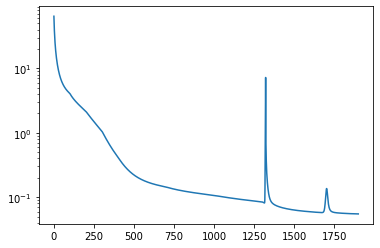

In [104]:
plt.plot(losses)
plt.yscale("log")
plt.show()

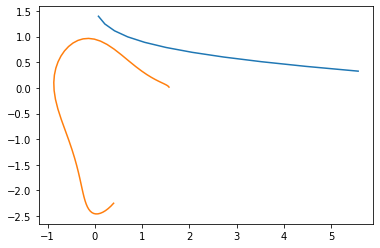

In [105]:
p = [Model.run(X[0])[0]]
q = [Model.run(X[0])[2]]
run = [Model.run(X[0])]

for i in range(10):
    run.append(Model.run(run[-1]))
    p.append(run[-1][0])
    q.append(run[-1][2])
    
plt.plot(q, p)
plt.plot(q0[1:], p0[1:])
plt.show()